#first we integerate the data and label using panda an os libraries

In [14]:
import os
import pandas as pd
import torch  
from torch.utils.data import Dataset, DataLoader  
from torchvision import transforms  
import cv2 
import albumentations as A  
from albumentations.pytorch import ToTensorV2  
import torch.nn as nn
import torch.optim as optim
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


dataset_path = "dataset"
categories = ["huskies", "wolves"]
data = []
for category in categories:
    folder_path = os.path.join(dataset_path, category) 
    label = categories.index(category)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        data.append([image_path, label])  # Store path and label
images = pd.DataFrame(data, columns=["image_path", "label"])
print(images.head)


<bound method NDFrame.head of                        image_path  label
0   dataset/huskies/husky_34.jpeg      0
1    dataset/huskies/husky_1.jpeg      0
2   dataset/huskies/husky_22.jpeg      0
3   dataset/huskies/husky_18.jpeg      0
4   dataset/huskies/husky_38.jpeg      0
..                            ...    ...
95     dataset/wolves/wolf_7.jpeg      1
96    dataset/wolves/wolf_25.jpeg      1
97    dataset/wolves/wolf_13.jpeg      1
98    dataset/wolves/wolf_44.jpeg      1
99    dataset/wolves/wolf_29.jpeg      1

[100 rows x 2 columns]>


In [15]:

train_im, test_im = train_test_split(images, test_size=0.2, random_state=42, stratify=images["label"])
print(train_im.head())


                       image_path  label
15  dataset/huskies/husky_12.jpeg      0
52     dataset/wolves/wolf_8.jpeg      1
60    dataset/wolves/wolf_46.jpeg      1
66    dataset/wolves/wolf_41.jpeg      1
68    dataset/wolves/wolf_17.jpeg      1


now we need to preprocess the dataset

In [ ]:



# Define augmentation transformations for training data
train_transforms = A.Compose([
    A.Resize(128, 128),  
    A.HorizontalFlip(p=0.5),  
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.5),  
    A.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),  
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
    ToTensorV2(), 
    ])
test_transforms = A.Compose([
    A.Resize(128, 128), 
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  
    ToTensorV2(), 
])



creating dataset class

In [17]:
class HuskyWolfDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe  
        self.transform = transform 
    def __len__(self):
        return len(self.dataframe)  
    def __getitem__(self, index):
        image_path = self.dataframe.iloc[index]["image_path"]  
        label = self.dataframe.iloc[index]["label"]  

        # Load image using OpenCV
        image = cv2.imread(image_path)  # Read image (BGR format)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply transformations (if any)
        if self.transform:
            augmented = self.transform(image=image)  # Apply transformations
            image = augmented["image"]

        return image, torch.tensor(label, dtype=torch.long)  # Return image & label as tensors


making instance of it

In [18]:
train_dataset = HuskyWolfDataset(train_im, transform=train_transforms)  
test_dataset = HuskyWolfDataset(test_im, transform=test_transforms)  


# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)


create the multilevel perceptron class using 3 hidden layers and relu + sigmoid activation functions


In [ ]:


class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.fc3 = nn.Linear(256, 128)  # Third hidden layer
        self.fc4 = nn.Linear(128, 1)  # Output layer (1 neuron for binary classification)
        self.relu = nn.ReLU()  # ReLU activation function
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x



used Grid Search to search for best hyperparameter set and calculated the accuracy along the way


In [24]:
results = []
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [20, 32, 64]
num_epochs_list = [50, 100]
optimizers = ["Adam", "SGD"]

# Hyperparameter tuning loop
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in num_epochs_list:
            for opt in optimizers:
                train_dataset = HuskyWolfDataset(train_im, transform=train_transforms)
                test_dataset = HuskyWolfDataset(test_im, transform=test_transforms)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Initialize model, loss, and optimizer
                model = MLPClassifier(input_size=128 * 128 * 3)
                criterion = nn.BCELoss()
                if opt == "SGD":
                    optimizer = optim.SGD(model.parameters(), lr=lr)
                else:
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                # Training loop
                for epoch in range(num_epochs):
                    print(f"Epoch {epoch + 1}/{num_epochs}")
                    model.train()
                    running_loss = 0.0
                    for images, labels in train_loader:
                        images = images.view(images.size(0), -1)
                        labels = labels.float().unsqueeze(1)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        running_loss += loss.item()

                # Evaluation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.view(images.size(0), -1)
                        labels = labels.float().unsqueeze(1)
                        outputs = model(images)
                        predicted = (outputs >= 0.5).float()
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                accuracy = 100 * correct / total
                results.append({
                    "Learning Rate": lr,
                    "Batch Size": batch_size,
                    "Epochs": num_epochs,
                    "Optimizer": opt,
                    "Test Accuracy": accuracy
                })

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/5

saved the results to a csv file

In [25]:
# Save results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)
print("Hyperparameter tuning results saved to hyperparameter_tuning_results.csv")

Hyperparameter tuning results saved to hyperparameter_tuning_results.csv


In [13]:
# # Evaluate the  model
# model.eval()  
# correct = 0
# total = 0

# with torch.no_grad():  # No gradient calculation during evaluation
#     for images, labels in test_loader:
#         images = images.view(images.size(0), -1)  
#         labels = labels.float().unsqueeze(1)  # Convert labels to float
        
#         # Forward pass
#         outputs = model(images)
        
#         # Convert probabilities to binary predictions (threshold = 0.5)
#         predicted = (outputs >= 0.5).float()  
        
#         # Count correct predictions
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

# # Compute accuracy
# accuracy = 100 * correct / total
# print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 100.00%


run the model on the best hyper parameters set

In [29]:
# Find the best hyperparameters
best_result = results_df.loc[results_df["Test Accuracy"].idxmax()]
print("Best Hyperparameters:")
print(best_result)

# Train the final model with the best hyperparameters
best_lr = best_result["Learning Rate"]
best_batch_size =int( best_result["Batch Size"])
best_epochs = best_result["Epochs"]
best_optimizer = best_result["Optimizer"]

# Create datasets and dataloaders

train_dataset = HuskyWolfDataset(train_im, transform=train_transforms)
test_dataset = HuskyWolfDataset(test_im, transform=test_transforms)
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLPClassifier(input_size=128 * 128 * 3)
criterion = nn.BCELoss()
if best_optimizer == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=best_lr)
else:
    optimizer = optim.Adam(model.parameters(), lr=best_lr)

# Training loop
for epoch in range(best_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)
        labels = labels.float().unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{best_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        labels = labels.float().unsqueeze(1)
        outputs = model(images)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Final Test Accuracy: {accuracy:.2f}%")

Best Hyperparameters:
Learning Rate    0.001
Batch Size          20
Epochs              50
Optimizer         Adam
Test Accuracy    100.0
Name: 0, dtype: object
Epoch [1/50], Loss: 0.4660
Epoch [2/50], Loss: 0.2820
Epoch [3/50], Loss: 0.2764
Epoch [4/50], Loss: 0.4935
Epoch [5/50], Loss: 0.3429
Epoch [6/50], Loss: 0.2571
Epoch [7/50], Loss: 0.4238
Epoch [8/50], Loss: 1.3880
Epoch [9/50], Loss: 0.0603
Epoch [10/50], Loss: 0.0650
Epoch [11/50], Loss: 0.0611
Epoch [12/50], Loss: 0.0533
Epoch [13/50], Loss: 0.1021
Epoch [14/50], Loss: 0.1075
Epoch [15/50], Loss: 0.0110
Epoch [16/50], Loss: 0.2525
Epoch [17/50], Loss: 0.0831
Epoch [18/50], Loss: 0.1012
Epoch [19/50], Loss: 0.1303
Epoch [20/50], Loss: 0.0229
Epoch [21/50], Loss: 0.1821
Epoch [22/50], Loss: 1.2797
Epoch [23/50], Loss: 1.3373
Epoch [24/50], Loss: 0.0846
Epoch [25/50], Loss: 0.0281
Epoch [26/50], Loss: 0.5235
Epoch [27/50], Loss: 0.1291
Epoch [28/50], Loss: 0.2007
Epoch [29/50], Loss: 0.1382
Epoch [30/50], Loss: 0.1111
Epoch [31

another approach using tthe cnn (better as it takes into consideration 2d features)

In [ ]:


class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3 channels (RGB), Output: 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust based on image size after pooling
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Conv1 -> ReLU
        x = self.pool(x)  # MaxPooling
        x = self.relu(self.conv2(x))  # Conv2 -> ReLU
        x = self.pool(x)  # MaxPooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))  # Fully connected layer
        x = self.sigmoid(self.fc2(x))  # Output layer
        return x

Apply the gradcam to ensure the model focuses on the object we want to classify based on rather than the back ground or any less important features 



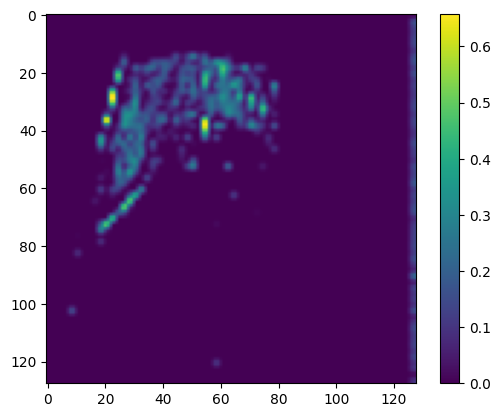

In [40]:


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook into the target layer to get activations and gradients
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Backward pass
        self.model.zero_grad()
        output[0, target_class].backward()

        # Compute gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Weight the activations by the gradients
        weights = np.mean(gradients, axis=(1, 2))
        heatmap = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            heatmap += w * activations[i]

        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        # Resize heatmap to match the input image size
        heatmap = cv2.resize(heatmap, (input_image.shape[3], input_image.shape[2]))
        return heatmap

# Example usage
model = CNNClassifier()
target_layer = model.conv2  # Last convolutional layer
grad_cam = GradCAM(model, target_layer)

# Generate heatmap for a test image
test_image, _ = test_dataset[2]  # Get a test image
test_image = test_image.unsqueeze(0)  # Add batch dimension
heatmap = grad_cam.generate_heatmap(test_image)

# Plot the heatmap
plt.imshow(heatmap)
plt.colorbar()
plt.show()

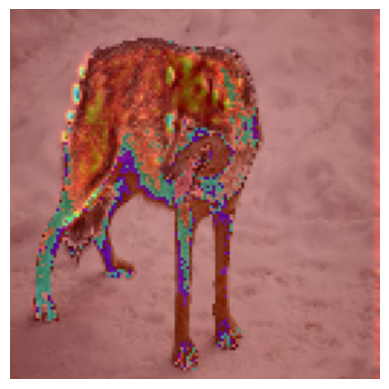

In [41]:
def overlay_heatmap(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    return superimposed_img

# Convert test image to numpy array
test_image_np = test_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
test_image_np = (test_image_np * 255).astype(np.uint8)  # Denormalize

# Overlay heatmap on the image
superimposed_img = overlay_heatmap(test_image_np, heatmap)

# Display the result
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

